In [1]:
 !pip install tensorflow_ranking tensorflow_probability numba torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 85.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 43.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 84.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1
from keras.optimizers import Adam

import torch

import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

import pickle

from VAE import Sampling, VAE, get_auth_model_from_latent_space, get_decoder, get_encoder
from VAE_torch import VAE as VAE_torch, Encoder, Decoder
from WAE import WAE
from scaler import CustomScaler

from featurize import filter as _filter, featurize, FILTER_INDICES
FILTER_INDICES = [0,1,2,3,4,5]

from visualise import *


2023-04-25 18:27:39.803448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 18:27:40.857501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-25 18:27:40.857633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-25 18:27:40.857658: W tensorfl

In [3]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
print(device_name)

file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]]
print(x_data.shape)

#from featurize import filter as _filter, ORDER, CUTOFF, FILTER_INDICES
#x_data = _filter(x_data, FILTER_INDICES, ORDER, CUTOFF)

y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)

###
np.random.seed(42)
kFold = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True)
val_map = next(kFold.split(x_data[train_gesture_map == 1], y_user[train_gesture_map == 1].argmax(axis=1) ))[1]
val_map_all = np.zeros(len(x_data[train_gesture_map == 1]))
val_map_all[val_map] = 1
val_map = val_map_all == 1



_map = (train_gesture_map == 1) & ((y_user.argmax(axis=1) >= 10))

user_x = x_data[_map]
user_y = y_user.argmax(axis=1)[_map]

def show_visuals(vae, is_wae=False, user_x = user_x, user_y=user_y, top_5 = False):
    
    #plot_standard_devs(vae, vae.scaler.transform(user_x), user_y)
    
    plot_label_clusters(vae, vae.scaler.transform(user_x), user_y, is_wae=is_wae, top_5=top_5)
    visualise(vae, vae.scaler.transform(user_x), user_y, 10, is_wae=is_wae, top_5=top_5)
    plot_reconstructed_curves(vae, vae.scaler.transform(user_x), channel=0, is_wae=is_wae)

def stitch_histories(history1, history2):
    for key in history1:
        history1[key] += list(history2[key])
    return history1


/device:GPU:0
(34255, 200, 6)


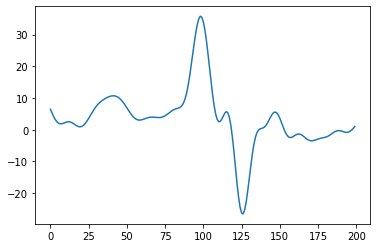

In [4]:
plt.plot(x_data[0,:,-1])

In [4]:
a = 1

Old data


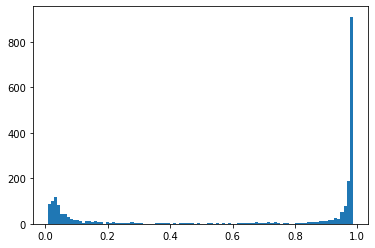

F1 score        : 0.8240850059031876
AUROC           : 0.9451948438064092
EER             : 0.12442396313364056
frr_at_eer      : 0.1271889400921659
far at zero frr : 0.9990783410138249
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10
New data


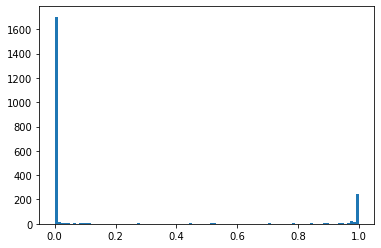

F1 score        : 0.4941176470588235
AUROC           : 0.7358062392490815
EER             : 0.24608294930875577
frr_at_eer      : 0.27004608294930876
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.1_10
New data


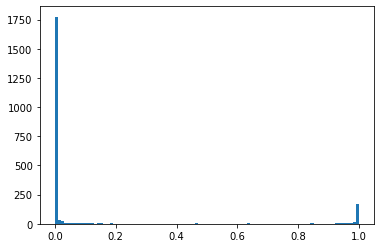

F1 score        : 0.3704256908140403
AUROC           : 0.7133823185882054
EER             : 0.24516129032258063
frr_at_eer      : 0.2764976958525346
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.01_10
New data


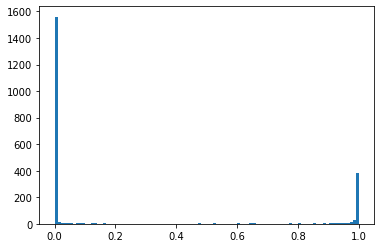

F1 score        : 0.6425000000000001
AUROC           : 0.7429021639873431
EER             : 0.22672811059907835
frr_at_eer      : 0.27004608294930876
far at zero frr : 0.9990783410138249
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.001_10
New data


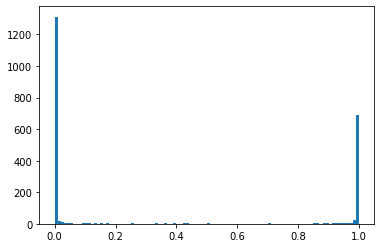

F1 score        : 0.8086021505376344
AUROC           : 0.8957161969886811
EER             : 0.09493087557603687
frr_at_eer      : 0.11612903225806452
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.0001_10
New data


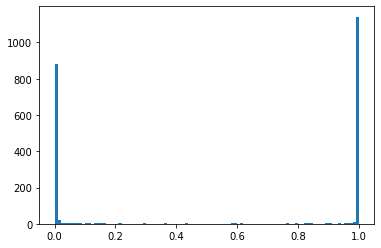

F1 score        : 0.8211169284467714
AUROC           : 0.8712336214402514
EER             : 0.19631336405529953
frr_at_eer      : 0.19723502304147467
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-05_10
New data


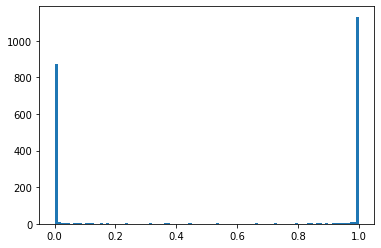

F1 score        : 0.7871416159860989
AUROC           : 0.8198687591581899
EER             : 0.2368663594470046
frr_at_eer      : 0.2368663594470046
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-06_10
New data


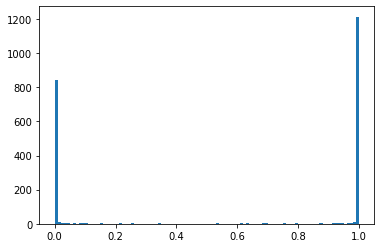

F1 score        : 0.827176220806794
AUROC           : 0.902762428592665
EER             : 0.19723502304147467
frr_at_eer      : 0.19723502304147467
far at zero frr : 0.9935483870967742
frr at 'zero' frr : 0.0009216589861751152
Old data


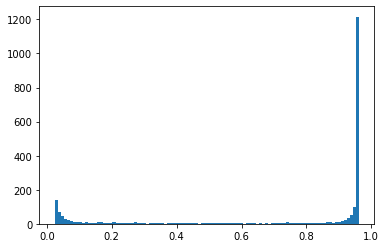

F1 score        : 0.7603669724770642
AUROC           : 0.8130004884367898
EER             : 0.2571428571428571
frr_at_eer      : 0.2571428571428571
far at zero frr : 0.9981566820276497
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10
New data


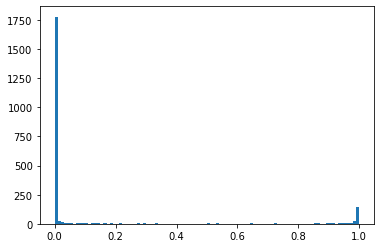

F1 score        : 0.3764002987303958
AUROC           : 0.7002650300494808
EER             : 0.28755760368663597
frr_at_eer      : 0.295852534562212
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.1_10
New data


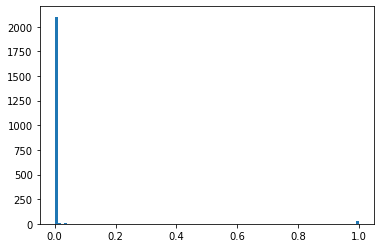

F1 score        : 0.06422836752899198
AUROC           : 0.767219945210134
EER             : 0.24516129032258063
frr_at_eer      : 0.24516129032258063
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.01_10
New data


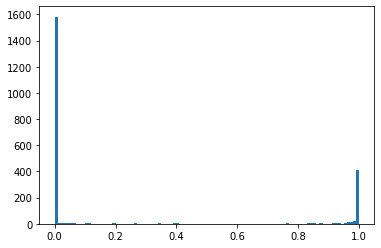

F1 score        : 0.6471321695760599
AUROC           : 0.7576941536239885
EER             : 0.24608294930875577
frr_at_eer      : 0.24976958525345622
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.001_10
New data


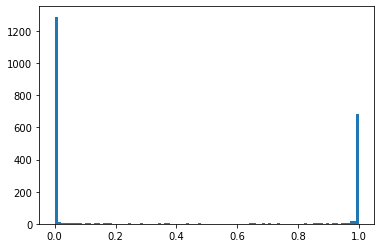

F1 score        : 0.8291644491750931
AUROC           : 0.9084699186646562
EER             : 0.12995391705069123
frr_at_eer      : 0.13179723502304147
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.0001_10
New data


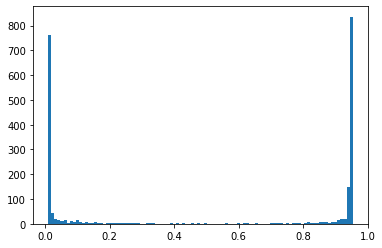

F1 score        : 0.7907184292726462
AUROC           : 0.856017753615494
EER             : 0.22119815668202766
frr_at_eer      : 0.22119815668202766
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-05_10
New data


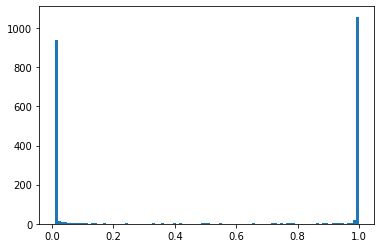

F1 score        : 0.8316120341266278
AUROC           : 0.8777548896769946
EER             : 0.19170506912442398
frr_at_eer      : 0.19170506912442398
far at zero frr : 0.9898617511520738
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-06_10
New data


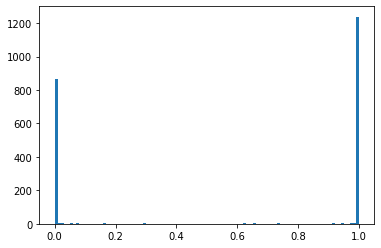

F1 score        : 0.8341111582520153
AUROC           : 0.8552710824183991
EER             : 0.21566820276497695
frr_at_eer      : 0.21566820276497695
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
Old data


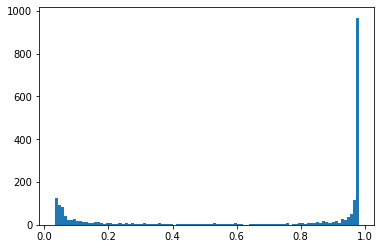

F1 score        : 0.8029595015576324
AUROC           : 0.9365660770031217
EER             : 0.15023041474654378
frr_at_eer      : 0.15115207373271888
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10
New data


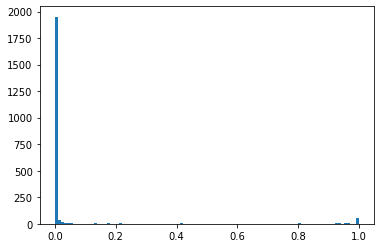

F1 score        : 0.09467455621301775
AUROC           : 0.6991186901399478
EER             : 0.25622119815668204
frr_at_eer      : 0.2608294930875576
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.1_10
New data


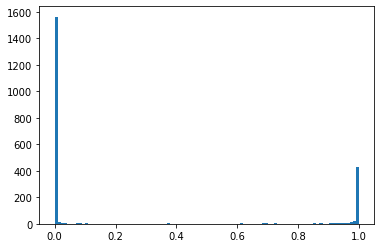

F1 score        : 0.6613201727328809
AUROC           : 0.8212941451294358
EER             : 0.2543778801843318
frr_at_eer      : 0.25806451612903225
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.01_10
New data


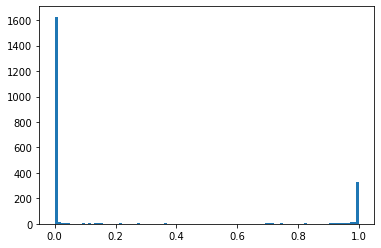

F1 score        : 0.5759162303664922
AUROC           : 0.7147299794007094
EER             : 0.2783410138248848
frr_at_eer      : 0.3244239631336406
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.001_10
New data


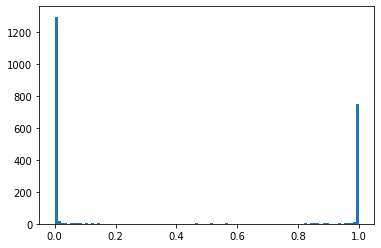

F1 score        : 0.8372827804107424
AUROC           : 0.9244418016946633
EER             : 0.13548387096774195
frr_at_eer      : 0.13548387096774195
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.0001_10
New data


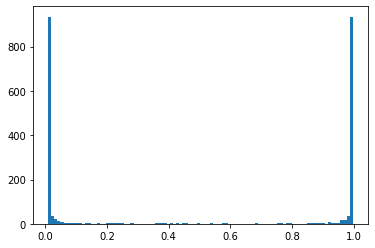

F1 score        : 0.812384473197782
AUROC           : 0.8604833400581876
EER             : 0.18525345622119815
frr_at_eer      : 0.18617511520737326
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-05_10
New data


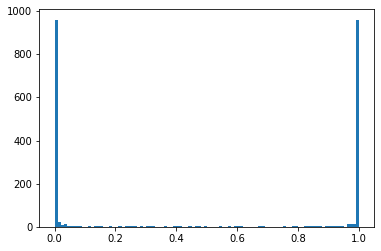

F1 score        : 0.7546296296296297
AUROC           : 0.8056089532587231
EER             : 0.24147465437788018
frr_at_eer      : 0.2423963133640553
far at zero frr : 0.9953917050691244
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-06_10
New data


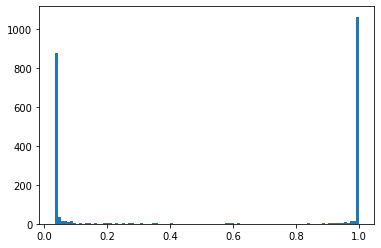

F1 score        : 0.8375838926174497
AUROC           : 0.8724020471872411
EER             : 0.18064516129032257
frr_at_eer      : 0.18064516129032257
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
Old data


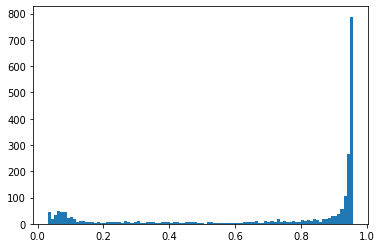

F1 score        : 0.7546754675467549
AUROC           : 0.8360852853107945
EER             : 0.23963133640552994
frr_at_eer      : 0.24147465437788018
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10
New data


In [ ]:
model_names = [ "naive_autoencoder_TORCH_softdtw_10", "naive_autoencoder_lbkeogh_mod_stats_10", "naive_autoencoder_mse_10","naive_autoencoder_lbkeogh_mod_10",  #  "naive_autoencoder_lbkeogh_10",
              "naive_autoencoder_mse_stats_10"] # "naive_autoencoder_lbkeogh_stats_10",
# "naive_autoencoder_TORCH_softdtw_10",

model_names = [ "naive_autoencoder_TORCH_softdtw_10"]

model_names = [f"vae_lbkeogh_mod_stats_beta={beta}_10" for beta in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]]

total_results = [] 

for rep in range(5):
    results_dict = {}

    #model_names = [ "naive_autoencoder_lbkeogh_mod_stats_v2_10"] #"naive_autoencoder_TORCH_softdtw",
    #model_names = ["wae_lbkeogh_mod_beta=0.0001_lsauth_10"]

    val_data_x = x_data[train_gesture_map==1][val_map]
    test_length = len(x_data[test_gesture_map == 1])

    
    old_data_x = np.concatenate([val_data_x, x_data[y_intent == 0][:240]], axis=0)
    old_scaler = CustomScaler()
    old_scaler.CHANNELS = 6
    old_data_x = old_scaler.fit_and_transform(old_data_x)
    old_data_y = np.concatenate([np.ones(len(val_data_x)), np.zeros(240)])



    old_test_x = np.concatenate([old_scaler.transform(x_data[test_gesture_map == 1]), x_data[y_intent == 0][240:240+test_length]])
    old_test_y = np.concatenate([np.ones(test_length), np.zeros(test_length)])

    print("Old data")
    old_model = get_complex_mix_model()
    old_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

    np.random.seed(1)
    classification_kFold = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    classification_val_map = next(kFold.split(old_data_x, old_data_y))[1]

    classification_val_map_all = np.zeros(len(val_data_x)+240)
    classification_val_map_all[classification_val_map] = 1
    classification_val_map = classification_val_map_all == 1

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=10,
                                                               patience=25, restore_best_weights=True)

    history = old_model.fit(old_data_x[~classification_val_map], old_data_y[~classification_val_map], epochs=300,
                            batch_size=32, verbose=0,
                            validation_data=(old_data_x[classification_val_map], old_data_y[classification_val_map]),
                       callbacks=[early_stopping_callback])

    output = np.squeeze(old_model(old_test_x))
    pred = np.squeeze(output > 0.5)
    results_dict["original"] = show_evaluate_model(old_test_y, pred, output)
    old_model = None
    del old_model
    
    for vae_model_name in model_names:
        print(vae_model_name)

        if "TORCH" in vae_model_name:
            with open(f'data/models/Gen/enc_{vae_model_name}.pickle', 'rb') as pickle_file:
                encoder = pickle.load(pickle_file)
            with open(f'data/models/Gen/dec_{vae_model_name}.pickle', 'rb') as pickle_file:
                decoder = pickle.load(pickle_file)
            vae = VAE_torch(latent_dim=10)
            vae.encoder = encoder
            vae.decoder = decoder
            vae.fit_scaler(np.swapaxes(x_data[test_gesture_map == 0], 1,2))
            encoder = None
            decoder = None
        else:
            if "wae" in vae_model_name:
                vae = WAE(None, None, None, None, scale_included=True)
            else:
                vae = VAE(None, None, None, None, scale_included=True, loss_func="MSE")
            vae.load_model("Gen", vae_model_name)

        #show_visuals(vae)

        train_data_x = vae.scaler.transform(x_data[train_gesture_map==1][~val_map])
        train_data_y = y_user[train_gesture_map==1][~val_map]

        val_data_x = vae.scaler.transform(x_data[train_gesture_map==1][val_map])
        val_data_y = y_user[train_gesture_map==1][val_map]

        if "TORCH" in vae_model_name:
            val_data_x = np.swapaxes(val_data_x, 1,2)
            new_data, _, _ = vae.encoder(torch.Tensor(val_data_x).to("cuda"))
            new_data = vae.scaler.inverse_transform(vae.decoder(new_data).detach().cpu().numpy())
            new_data = np.swapaxes(new_data, 1,2)
            val_data_x = np.swapaxes(val_data_x, 1,2)
        elif "wae" in vae_model_name:
            new_data = vae.encoder(val_data_x)
            new_data = vae.scaler.inverse_transform(vae.decoder(new_data).numpy())
        else:
            new_data, _, _ = vae.encoder(val_data_x)
            new_data = vae.scaler.inverse_transform(vae.decoder(new_data).numpy())


        new_data_x = np.concatenate([new_data, x_data[y_intent == 0][:240]], axis=0)
        new_scaler = CustomScaler()
        new_scaler.CHANNELS = 6
        new_data_x = new_scaler.fit_and_transform(new_data_x)
        new_data_y = np.concatenate([np.ones(len(new_data)), np.zeros(240)])


        new_test_x = np.concatenate([new_scaler.transform(x_data[test_gesture_map == 1]), x_data[y_intent == 0][240:240+test_length]])
        new_test_y = np.concatenate([np.ones(test_length), np.zeros(test_length)])


        print("New data")
        new_model = get_complex_mix_model()
        new_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

        np.random.seed(1)
        classification_kFold = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
        classification_val_map = next(kFold.split(new_data_x, new_data_y))[1]

        classification_val_map_all = np.zeros(len(new_data_x))
        classification_val_map_all[classification_val_map] = 1
        classification_val_map = classification_val_map_all == 1

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=10,
                                                                   patience=25, restore_best_weights=True)

        history = new_model.fit(new_data_x[~classification_val_map], new_data_y[~classification_val_map], epochs=300,
                                batch_size=32, verbose=0,
                                validation_data=(new_data_x[classification_val_map], new_data_y[classification_val_map]),
                           callbacks=[early_stopping_callback])

        output = np.squeeze(new_model(new_test_x))
        pred = np.squeeze(output > 0.5)
        results_dict[vae_model_name] = show_evaluate_model(new_test_y, pred, output)

        new_model = None
        del new_model
        
    total_results.append(results_dict)

    import pickle
    with open("data/stats/Gen/TSTR_intent_vaes_final.pickle", "wb") as file:
        pickle.dump(total_results, file)

with open("data/stats/Gen/TSTR_intent_vaes_final.pickle", "wb") as file:
    pickle.dump(total_results, file)
    
# vaes is also saved down now :-)

In [8]:
with open("data/stats/Gen/TSTR_intent_WatchAuth_repeated.pickle", "rb") as file:
    total_results_WA = pickle.load(file)
    
with open("data/stats/Gen/TSTR_intent_repeated.pickle", "rb") as file:
    total_results_DL = pickle.load(file)


with open("data/stats/Gen/TSTR_intent_repeated_original.pickle", "rb") as file:
    total_results_DL_original = pickle.load(file)
    
with open("data/stats/Gen/TSTR_intent_vaes_final.pickle", "rb") as file:
    total_results_vaes = pickle.load(file)
    
total_results = total_results_vaes

In [10]:
import pickle
model_names = list(total_results[0].keys())

#with open("data/stats/Gen/TSTR_intent_part_2.pickle", "wb") as file:
#    pickle.dump(results_dict, file)
#results_dict
for model in model_names: # ["original"] + 
    print(model)
    stat = "eer"
    total = 0
    for d in total_results:
        total += d[model][stat] / 5
    print(total)


original
0.1456221198156682
vae_lbkeogh_mod_stats_beta=1_10
0.2328110599078341
vae_lbkeogh_mod_stats_beta=0.1_10
0.2792626728110599
vae_lbkeogh_mod_stats_beta=0.01_10
0.2731797235023042
vae_lbkeogh_mod_stats_beta=0.001_10
0.1456221198156682
vae_lbkeogh_mod_stats_beta=0.0001_10
0.20313364055299538
vae_lbkeogh_mod_stats_beta=1e-05_10
0.20829493087557602
vae_lbkeogh_mod_stats_beta=1e-06_10
0.20073732718894008


In [22]:
import pickle
#with open("data/stats/Gen/TSTR_intent_part_2.pickle", "wb") as file:
#    pickle.dump(results_dict, file)
#results_dict
for stat in ["eer", "far", "fmeasure", "auroc"]:
    print(stat)
    for model in model_names: # 
        print(model)

        total = 0
        for d in total_results:
            total += d[model][stat] / 5
        print(total)

eer
original
0.1456221198156682
vae_lbkeogh_mod_stats_beta=1_10
0.2328110599078341
vae_lbkeogh_mod_stats_beta=0.1_10
0.2792626728110599
vae_lbkeogh_mod_stats_beta=0.01_10
0.2731797235023042
vae_lbkeogh_mod_stats_beta=0.001_10
0.1456221198156682
vae_lbkeogh_mod_stats_beta=0.0001_10
0.20313364055299538
vae_lbkeogh_mod_stats_beta=1e-05_10
0.20829493087557602
vae_lbkeogh_mod_stats_beta=1e-06_10
0.20073732718894008
far
original
0.9653456221198157
vae_lbkeogh_mod_stats_beta=1_10
0.9994470046082948
vae_lbkeogh_mod_stats_beta=0.1_10
1.0
vae_lbkeogh_mod_stats_beta=0.01_10
0.9966820276497697
vae_lbkeogh_mod_stats_beta=0.001_10
0.9968663594470046
vae_lbkeogh_mod_stats_beta=0.0001_10
0.9959447004608295
vae_lbkeogh_mod_stats_beta=1e-05_10
1.0
vae_lbkeogh_mod_stats_beta=1e-06_10
1.0
fmeasure
original
0.8091831631858497
vae_lbkeogh_mod_stats_beta=1_10
0.3406675986858225
vae_lbkeogh_mod_stats_beta=0.1_10
0.4551101519151165
vae_lbkeogh_mod_stats_beta=0.01_10
0.3850526336599442
vae_lbkeogh_mod_stats_bet

In [48]:
"""data/stats/Gen/TSTR_intent_WatchAuth.pickle"""
with open("data/stats/Gen/TSTR_intent_WatchAuth.pickle", "rb") as file:
    results_dict1 = pickle.load(file)

results_dict1

{'original': {'fmeasure': 0.9615745079662606,
  'auroc': 0.9893363630571896,
  'eer_theta': 0.48,
  'eer': 0.03870967741935484,
  'frr_at_eer': 0.041474654377880185,
  'far_theta': 0.13,
  'far': 0.9935483870967742,
  'frr_at_zero_frr': 0.0009216589861751152,
  'accuracy': 0.9622119815668203},
 'naive_autoencoder_mse_10': {'fmeasure': 0.9601126231816048,
  'auroc': 0.9886151755186986,
  'eer_theta': 0.47,
  'eer': 0.04055299539170507,
  'frr_at_eer': 0.04331797235023042,
  'far_theta': 0.14,
  'far': 0.9935483870967742,
  'frr_at_zero_frr': 0.0009216589861751152,
  'accuracy': 0.9608294930875576},
 'naive_autoencoder_lbkeogh_10': {'fmeasure': 0.9773880941393631,
  'auroc': 0.9947805219902737,
  'eer_theta': 0.51,
  'eer': 0.02119815668202765,
  'frr_at_eer': 0.023963133640552997,
  'far_theta': 0.25,
  'far': 0.6820276497695853,
  'frr_at_zero_frr': 0.0009216589861751152,
  'accuracy': 0.9774193548387097},
 'naive_autoencoder_lbkeogh_mod_10': {'fmeasure': 0.9783310281235593,
  'auroc':

Old data


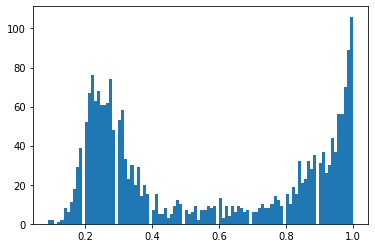

F1 score        : 0.9566854990583804
AUROC           : 0.9840378857057912
EER             : 0.03963133640552995
frr_at_eer      : 0.0423963133640553
far at zero frr : 0.9990783410138249
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10


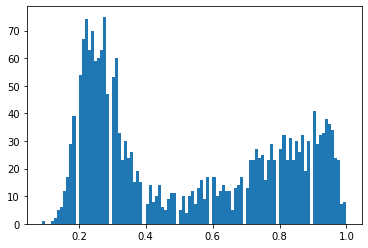

F1 score        : 0.9512541410317085
AUROC           : 0.9874259381171824
EER             : 0.0423963133640553
frr_at_eer      : 0.05161290322580645
far at zero frr : 0.96036866359447
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.1_10


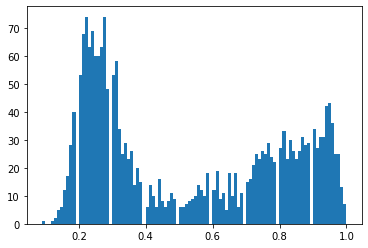

F1 score        : 0.9517502365184484
AUROC           : 0.9879063050818663
EER             : 0.0423963133640553
frr_at_eer      : 0.04976958525345622
far at zero frr : 0.9345622119815669
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.01_10


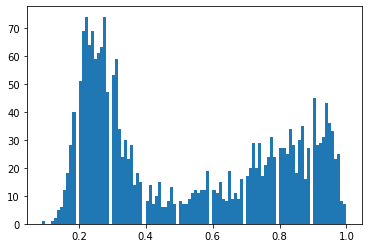

F1 score        : 0.9502605400284225
AUROC           : 0.9871749240799337
EER             : 0.0423963133640553
frr_at_eer      : 0.052534562211981564
far at zero frr : 0.976036866359447
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.001_10


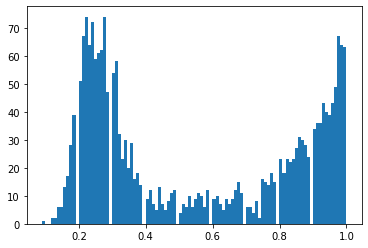

F1 score        : 0.9561940650023552
AUROC           : 0.9876905434390197
EER             : 0.0423963133640553
frr_at_eer      : 0.0423963133640553
far at zero frr : 0.9963133640552996
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.0001_10


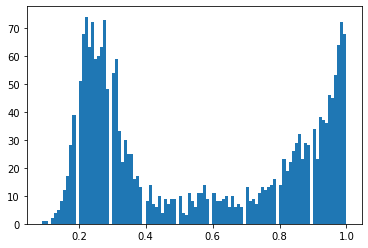

F1 score        : 0.9547169811320755
AUROC           : 0.9846915415489819
EER             : 0.0423963133640553
frr_at_eer      : 0.04423963133640553
far at zero frr : 0.9990783410138249
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-05_10


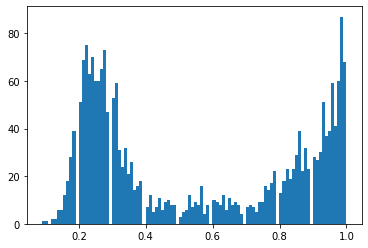

F1 score        : 0.9581570286788904
AUROC           : 0.9856981460638365
EER             : 0.03963133640552995
frr_at_eer      : 0.04423963133640553
far at zero frr : 0.9990783410138249
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-06_10


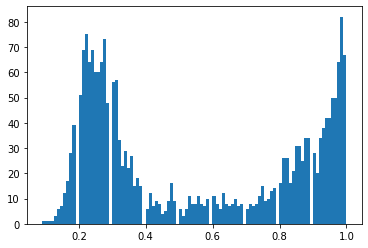

F1 score        : 0.9547169811320755
AUROC           : 0.9843955063815328
EER             : 0.0423963133640553
frr_at_eer      : 0.04331797235023042
far at zero frr : 0.9990783410138249
frr at 'zero' frr : 0.0009216589861751152
Old data


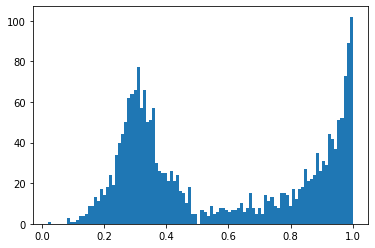

F1 score        : 0.9588652482269503
AUROC           : 0.9790371424324152
EER             : 0.047926267281105994
frr_at_eer      : 0.04976958525345622
far at zero frr : 0.9972350230414746
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10


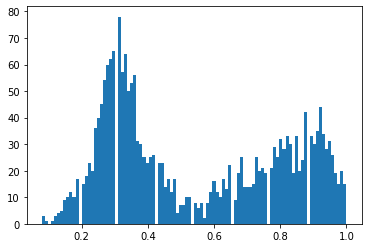

F1 score        : 0.9549121974371143
AUROC           : 0.9793467688844528
EER             : 0.047926267281105994
frr_at_eer      : 0.053456221198156684
far at zero frr : 0.9935483870967742
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.1_10


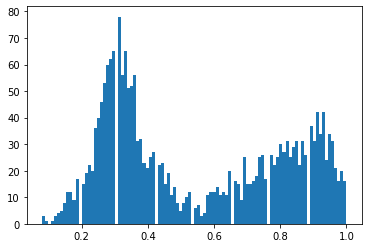

F1 score        : 0.9554079696394688
AUROC           : 0.9794155747626834
EER             : 0.047926267281105994
frr_at_eer      : 0.052534562211981564
far at zero frr : 0.9935483870967742
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.01_10


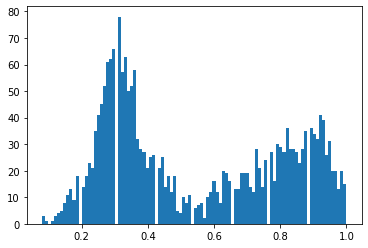

F1 score        : 0.9549121974371143
AUROC           : 0.979023126420183
EER             : 0.047926267281105994
frr_at_eer      : 0.053456221198156684
far at zero frr : 0.9935483870967742
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.001_10


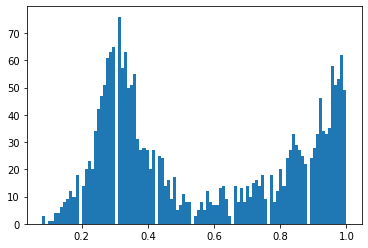

F1 score        : 0.9563981042654027
AUROC           : 0.979061351908089
EER             : 0.047926267281105994
frr_at_eer      : 0.053456221198156684
far at zero frr : 0.9963133640552996
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.0001_10


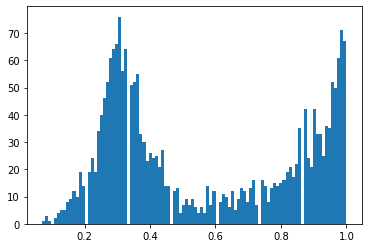

F1 score        : 0.9563981042654027
AUROC           : 0.9770337021385037
EER             : 0.047926267281105994
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.9972350230414746
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-05_10


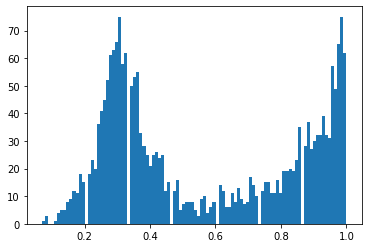

F1 score        : 0.9568924680246328
AUROC           : 0.978609866423156
EER             : 0.047926267281105994
frr_at_eer      : 0.05161290322580645
far at zero frr : 0.9963133640552996
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-06_10


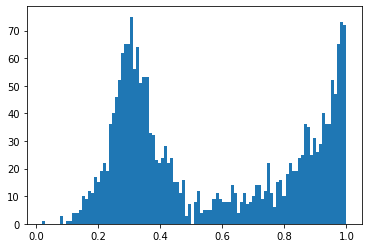

F1 score        : 0.9559032716927454
AUROC           : 0.9770001486546753
EER             : 0.047926267281105994
frr_at_eer      : 0.05622119815668203
far at zero frr : 0.9972350230414746
frr at 'zero' frr : 0.0009216589861751152
Old data


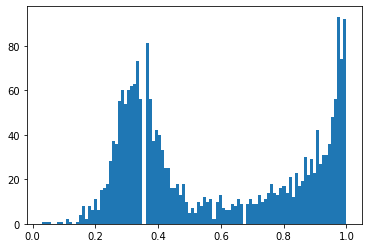

F1 score        : 0.9610876699484294
AUROC           : 0.9799358661258469
EER             : 0.04423963133640553
frr_at_eer      : 0.047926267281105994
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10


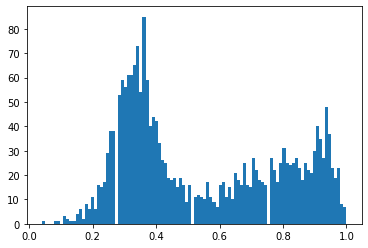

F1 score        : 0.9437559580552909
AUROC           : 0.9743498481598675
EER             : 0.054377880184331796
frr_at_eer      : 0.0663594470046083
far at zero frr : 0.9981566820276497
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.1_10


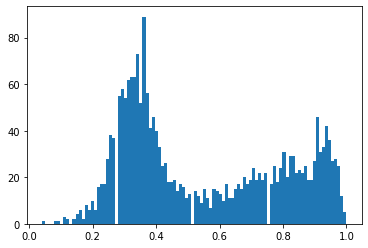

F1 score        : 0.9452641599238458
AUROC           : 0.9750731593365755
EER             : 0.054377880184331796
frr_at_eer      : 0.06451612903225806
far at zero frr : 0.9981566820276497
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.01_10


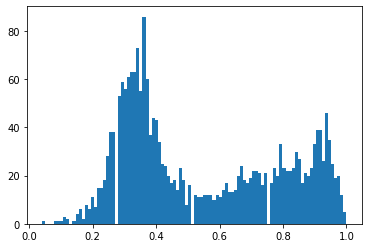

F1 score        : 0.9422434367541767
AUROC           : 0.9737603261908301
EER             : 0.054377880184331796
frr_at_eer      : 0.06543778801843318
far at zero frr : 0.9981566820276497
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.001_10


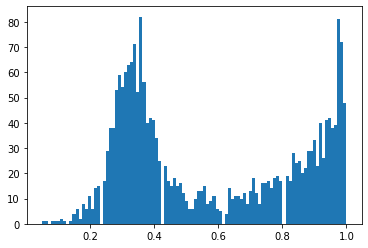

F1 score        : 0.9601126231816048
AUROC           : 0.9833060799762152
EER             : 0.04423963133640553
frr_at_eer      : 0.04608294930875576
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.0001_10


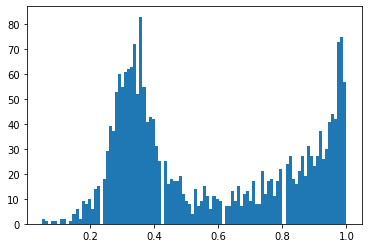

F1 score        : 0.9532357109116674
AUROC           : 0.9777187878273057
EER             : 0.04423963133640553
frr_at_eer      : 0.05622119815668203
far at zero frr : 1.0
frr at 'zero' frr : 0.0
vae_lbkeogh_mod_stats_beta=1e-05_10


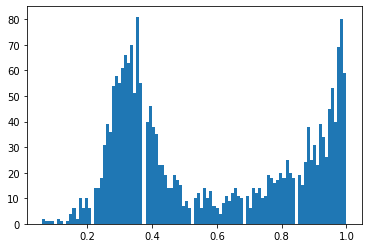

F1 score        : 0.9576669802445907
AUROC           : 0.9801728641508634
EER             : 0.04423963133640553
frr_at_eer      : 0.04884792626728111
far at zero frr : 1.0
frr at 'zero' frr : 0.0
vae_lbkeogh_mod_stats_beta=1e-06_10


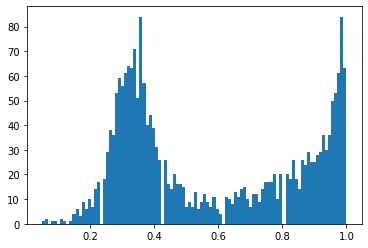

F1 score        : 0.9547169811320755
AUROC           : 0.9779281785555013
EER             : 0.04423963133640553
frr_at_eer      : 0.055299539170506916
far at zero frr : 1.0
frr at 'zero' frr : 0.0009216589861751152
Old data


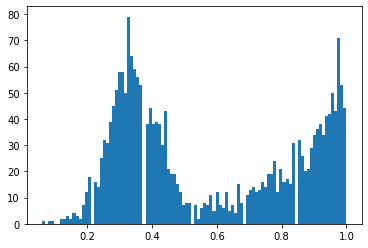

F1 score        : 0.9562737642585551
AUROC           : 0.9784752277601988
EER             : 0.0423963133640553
frr_at_eer      : 0.054377880184331796
far at zero frr : 0.9981566820276497
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10


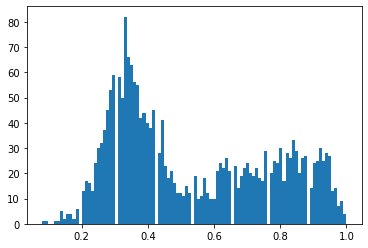

F1 score        : 0.9437229437229437
AUROC           : 0.9747219095754848
EER             : 0.05622119815668203
frr_at_eer      : 0.06728110599078341
far at zero frr : 0.9963133640552996
frr at 'zero' frr : 0.0
vae_lbkeogh_mod_stats_beta=0.1_10


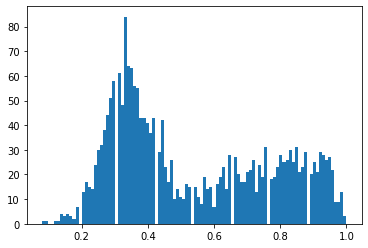

F1 score        : 0.9452449567723342
AUROC           : 0.9759438510055427
EER             : 0.05622119815668203
frr_at_eer      : 0.06543778801843318
far at zero frr : 0.9935483870967742
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.01_10


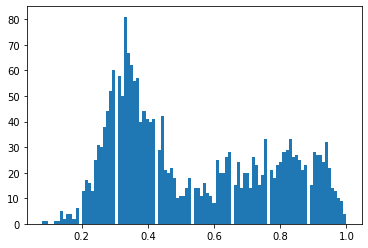

F1 score        : 0.9437229437229437
AUROC           : 0.9748412580432797
EER             : 0.05622119815668203
frr_at_eer      : 0.06543778801843318
far at zero frr : 0.9963133640552996
frr at 'zero' frr : 0.0
vae_lbkeogh_mod_stats_beta=0.001_10


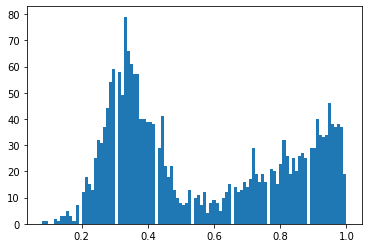

F1 score        : 0.9552806850618458
AUROC           : 0.9784098197031155
EER             : 0.0423963133640553
frr_at_eer      : 0.05622119815668203
far at zero frr : 0.9935483870967742
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.0001_10


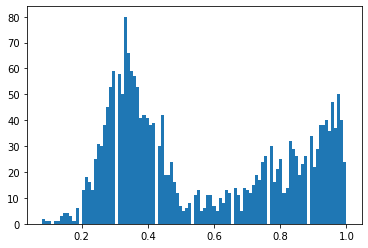

F1 score        : 0.9512893982808023
AUROC           : 0.9771207713054004
EER             : 0.0423963133640553
frr_at_eer      : 0.05806451612903226
far at zero frr : 0.9981566820276497
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-05_10


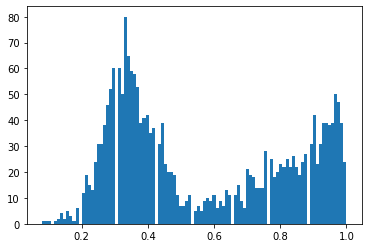

F1 score        : 0.9532888465204957
AUROC           : 0.9774822145299329
EER             : 0.0423963133640553
frr_at_eer      : 0.05622119815668203
far at zero frr : 0.9972350230414746
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-06_10


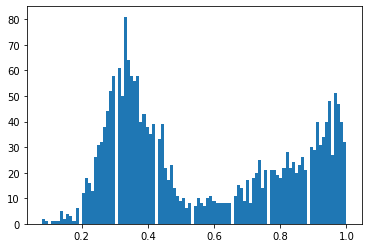

F1 score        : 0.9527896995708155
AUROC           : 0.9764543736329079
EER             : 0.0423963133640553
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.9981566820276497
frr at 'zero' frr : 0.0009216589861751152
Old data


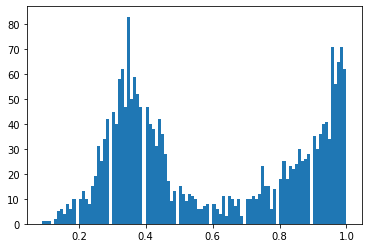

F1 score        : 0.9510489510489512
AUROC           : 0.9721582535199303
EER             : 0.04884792626728111
frr_at_eer      : 0.05806451612903226
far at zero frr : 0.9981566820276497
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1_10


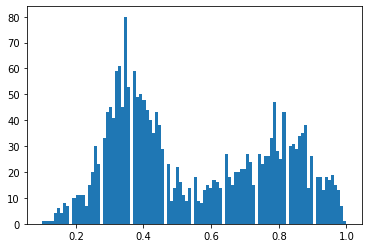

F1 score        : 0.9391796322489392
AUROC           : 0.9724496166833019
EER             : 0.06359447004608294
frr_at_eer      : 0.06728110599078341
far at zero frr : 0.9843317972350231
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.1_10


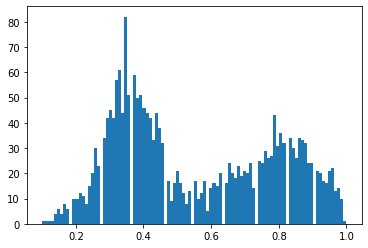

F1 score        : 0.940677966101695
AUROC           : 0.9732663679415574
EER             : 0.06359447004608294
frr_at_eer      : 0.06359447004608294
far at zero frr : 0.9843317972350231
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.01_10


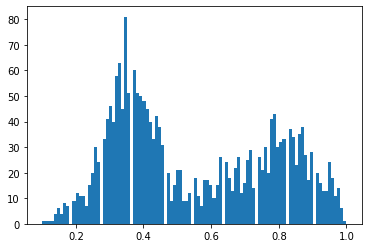

F1 score        : 0.939679547596607
AUROC           : 0.9720533457920109
EER             : 0.06359447004608294
frr_at_eer      : 0.0663594470046083
far at zero frr : 0.9843317972350231
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.001_10


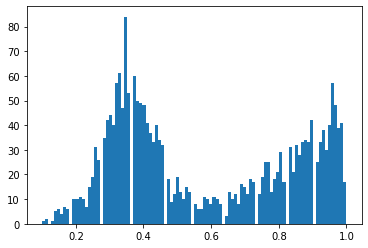

F1 score        : 0.9481065918653576
AUROC           : 0.9740729257363716
EER             : 0.05806451612903226
frr_at_eer      : 0.05806451612903226
far at zero frr : 0.9972350230414746
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=0.0001_10


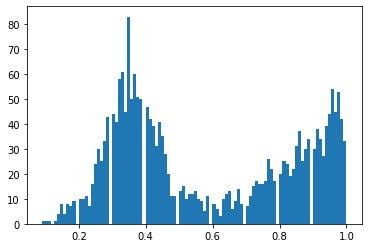

F1 score        : 0.9490892106492292
AUROC           : 0.9705863365117119
EER             : 0.05806451612903226
frr_at_eer      : 0.06267281105990784
far at zero frr : 0.9935483870967742
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-05_10


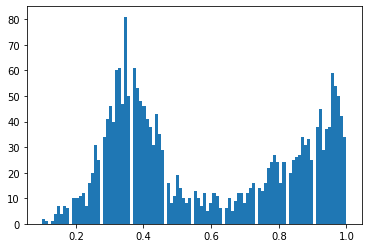

F1 score        : 0.9495798319327731
AUROC           : 0.9719981311983691
EER             : 0.04884792626728111
frr_at_eer      : 0.05714285714285714
far at zero frr : 0.9935483870967742
frr at 'zero' frr : 0.0009216589861751152
vae_lbkeogh_mod_stats_beta=1e-06_10


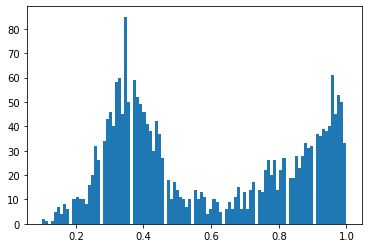

F1 score        : 0.9471221338324753
AUROC           : 0.9697283866720466
EER             : 0.05806451612903226
frr_at_eer      : 0.059907834101382486
far at zero frr : 0.9972350230414746
frr at 'zero' frr : 0.0009216589861751152


In [23]:
## Doing WatchAuth instead...

model_names = ["naive_autoencoder_mse_10", "naive_autoencoder_lbkeogh_10","naive_autoencoder_lbkeogh_mod_10",
              "naive_autoencoder_mse_stats_10", "naive_autoencoder_lbkeogh_stats_10","naive_autoencoder_lbkeogh_mod_stats_10",
              "naive_autoencoder_lbkeogh_mod_stats_v2_10", "naive_autoencoder_lbkeogh_mod_stats_v3_10"] # "TORCH_softdtw"

model_names = [ "naive_autoencoder_TORCH_softdtw_10", "naive_autoencoder_lbkeogh_mod_stats_10", "naive_autoencoder_mse_10","naive_autoencoder_lbkeogh_mod_10",  #  "naive_autoencoder_lbkeogh_10",
              "naive_autoencoder_mse_stats_10"]

model_names = [f"vae_lbkeogh_mod_stats_beta={beta}_10" for beta in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]]

# "TORCH_softdtw", 

_vae = VAE(None, None, None, None, scale_included=True, loss_func="MSE")

total_results = []

for rep in range(5):

    results_dict = {}

    #model_names = [ "naive_autoencoder_lbkeogh_mod_stats_v2_10"] #"naive_autoencoder_TORCH_softdtw",

    val_data_x = x_data[train_gesture_map==1][val_map]
    test_length = len(x_data[test_gesture_map == 1])

    new_indices = np.random.choice(len(x_data[y_intent==0]), size=240 + test_length, replace=False)
    train_zero_data = x_data[y_intent==0][new_indices[:240]]
    test_zero_data = x_data[y_intent==0][new_indices[240:]]


    old_data_x = np.concatenate([val_data_x, train_zero_data], axis=0)
    old_scaler = CustomScaler()
    old_scaler.CHANNELS = 6
    old_data_x = old_scaler.fit_and_transform(old_data_x)
    old_data_y = np.concatenate([np.ones(len(val_data_x)), np.zeros(240)])

    old_data_x = _vae.vae_featurize(old_data_x)


    old_test_x = np.concatenate([old_scaler.transform(x_data[test_gesture_map == 1]), test_zero_data])
    old_test_x = _vae.vae_featurize(old_test_x)
    old_test_y = np.concatenate([np.ones(test_length), np.zeros(test_length)])


    print("Old data")
    model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced").fit(old_data_x, old_data_y)
    pred = model.predict(old_test_x)
    output = model.predict_proba(old_test_x)[:, 1]

    results_dict["original"] = show_evaluate_model(old_test_y, pred, output)
    old_model = None
    del old_model

    for vae_model_name in model_names:
        print(vae_model_name)

        if "TORCH" in vae_model_name:
            with open(f'data/models/Gen/enc_{vae_model_name}.pickle', 'rb') as pickle_file:
                encoder = pickle.load(pickle_file)
            with open(f'data/models/Gen/dec_{vae_model_name}.pickle', 'rb') as pickle_file:
                decoder = pickle.load(pickle_file)
            vae = VAE_torch(latent_dim=10)
            vae.encoder = encoder
            vae.decoder = decoder
            vae.fit_scaler(np.swapaxes(x_data[test_gesture_map == 0], 1,2))
            encoder = None
            decoder = None
        else:
            if "wae" in vae_model_name:
                vae = WAE(None, None, None, None, scale_included=True)
            else:
                vae = VAE(None, None, None, None, scale_included=True, loss_func="MSE")
            vae.load_model("Gen", vae_model_name)

        #show_visuals(vae)

        train_data_x = vae.scaler.transform(x_data[train_gesture_map==1][~val_map])
        train_data_y = y_user[train_gesture_map==1][~val_map]

        val_data_x = vae.scaler.transform(x_data[train_gesture_map==1][val_map])
        val_data_y = y_user[train_gesture_map==1][val_map]

        if "TORCH" in vae_model_name:
            val_data_x = np.swapaxes(val_data_x, 1,2)
            new_data, _, _ = vae.encoder(torch.Tensor(val_data_x).to("cuda"))
            new_data = vae.scaler.inverse_transform(vae.decoder(new_data).detach().cpu().numpy())
            new_data = np.swapaxes(new_data, 1,2)
            val_data_x = np.swapaxes(val_data_x, 1,2)
        elif "wae" in vae_model_name:
            new_data = vae.encoder(val_data_x)
            new_data = vae.scaler.inverse_transform(vae.decoder(new_data).numpy())
        else:
            new_data, _, _ = vae.encoder(val_data_x)
            new_data = vae.scaler.inverse_transform(vae.decoder(new_data).numpy())


        #new_data = filter(new_data, [0,1,2,3,4,5], 6, 3.667)

        new_data_x = np.concatenate([new_data, train_zero_data], axis=0)
        new_scaler = CustomScaler()
        new_scaler.CHANNELS = 6
        new_data_x = new_scaler.fit_and_transform(new_data_x)
        new_data_y = np.concatenate([np.ones(len(val_data_x)), np.zeros(240)])

        new_data_x = _vae.vae_featurize(new_data_x)


        new_test_x = np.concatenate([new_scaler.transform(x_data[test_gesture_map == 1]), test_zero_data])
        new_test_x = _vae.vae_featurize(new_test_x)
        new_test_y = np.concatenate([np.ones(test_length), np.zeros(test_length)])

        model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced").fit(old_data_x, old_data_y)
        pred = model.predict(new_test_x)
        output = model.predict_proba(new_test_x)[:, 1]

        results_dict[vae_model_name] = show_evaluate_model(new_test_y, pred, output)

        new_model = None
        del new_model
    
    total_results.append(results_dict)
    
    with open("data/stats/Gen/TSTR_intent_WatchAuth_vaes_final.pickle", "wb") as file:
        pickle.dump(total_results, file)


with open("data/stats/Gen/TSTR_intent_WatchAuth_vaes_final.pickle", "wb") as file:
    pickle.dump(total_results, file)

In [39]:
import pickle
with open("data/stats/Gen/TSTR_intent_WatchAuth.pickle", "wb") as file:
    pickle.dump(results_dict, file)

In [12]:
def get_complex_mix_model():

    input_dim = (200,6)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    y = inputs
    
    
    
    last_output_channels = 22
    for a in range(4):
        x0 = Conv1D(last_output_channels, 1, strides=1, padding="same", activation="relu")(x)
        x1 = Conv1D(last_output_channels, 3, strides=1, padding="same", activation="relu")(x)
        x2 = Conv1D(last_output_channels, 5, strides=1, padding="same", activation="relu")(x)
        x3 = Conv1D(last_output_channels, 10, strides=1, padding="same", activation="relu")(x)
        x0 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x0)
        x1 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x1)
        x2 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x2)
        x3 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x3)
        x = layers.Concatenate()([x0,x1,x2,x3])
        
        x = layers.TimeDistributed(Dense(30, activation="relu"))(x) # , kernel_regularizer=keras.regularizers.L1(1e-4)))(x) # 
        
        
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(32)(x)

    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="complex_conv_GRU_classifier")
    
    return model

In [13]:
def get_eer(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    unique_scores_legit = sorted(set(scores_legit))
    
    #treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
    for c, threshold in enumerate(unique_scores_legit):
        frr = sum(1 if x < threshold else 0 for x in scores_legit) / len(scores_legit)
        far = sum(1 if x >= threshold else 0 for x in scores_adv) / len(scores_adv)
        if frr >= far:
            return threshold, far, frr
    print("Failure")

def get_far_when_zero_frr(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    unique_scores_legit = sorted(set(scores_legit))
    
    last_far = 1.0
    last_frr = 0.0
    last_threshold = 0.0
    
    #treat each legitimate sample distance as a possible threshold, determine the point with the lowest FAR that satisfies the condition that FRR = 0
    for c, threshold in enumerate(unique_scores_legit):
        frr = sum(1 if x < threshold else 0 for x in scores_legit) / len(scores_legit)
        far = sum(1 if x >= threshold else 0 for x in scores_adv) / len(scores_adv)
        if frr > 0.001:
            return last_threshold, last_far, last_frr
        last_far = far
        last_frr = frr
        last_threshold = threshold

scores_legit = [i / 100 for i in range(30,101)]
scores_adv = [i / 100 for i in range(5, 85)]
display(get_eer(scores_legit, scores_adv))
display(get_far_when_zero_frr(scores_legit, scores_adv))

(0.56, 0.3625, 0.36619718309859156)

(0.3, 0.6875, 0.0)

In [14]:
def show_evaluate_model(labels_test, labels_pred, labels_scores, verbose = 1):
    

    fmeasure = f1_score(labels_test, labels_pred, average = "binary", labels = np.unique(labels_pred)) 
    auroc = sklearn.metrics.roc_auc_score(labels_test, labels_scores, labels = np.unique(labels_pred))

    scores_legit = [labels_scores[i] for i in range(len(labels_test)) if 1 == labels_test[i]]
    scores_adv = [labels_scores[i] for i in range(len(labels_test)) if 0 == labels_test[i]]

    eer_theta, eer, frr_at_eer = get_eer(scores_legit, scores_adv)
    far_theta, far, frr_at_zero_frr = get_far_when_zero_frr(scores_legit, scores_adv)
    
    if verbose:
        plt.hist(labels_scores, bins=100)
        plt.show()
        print(f"F1 score        : {fmeasure}")
        print(f"AUROC           : {auroc}")
        print(f"EER             : {eer}")
        print(f"frr_at_eer      : {frr_at_eer}")
        print(f"far at zero frr : {far}")
        print(f"frr at 'zero' frr : {frr_at_zero_frr}")

    accuracy = sum(labels_test == labels_pred) / len(labels_test)
    
    return {"fmeasure":fmeasure, "auroc":auroc, "eer_theta":eer_theta, "eer":eer, "frr_at_eer":frr_at_eer, 
            "far_theta":far_theta, "far":far, "frr_at_zero_frr":frr_at_zero_frr, "accuracy":accuracy}